# Implement the TICTACTOE Game using Reinforcement Learning

In [ ]:
## Reference: https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542

## **Importing the library**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Initialization

In [2]:

BOARD_ROWS=3
BOARD_COLS=3
BOARD_SIZE=BOARD_ROWS*BOARD_COLS

## Setup State

In [3]:
class State:
  def __init__(self,p1,p2):
    self.board=np.zeros((BOARD_ROWS,BOARD_COLS))
    self.p1=p1
    self.p2=p2
    self.isEnd=False
    self.boardHash=None
    self.playerSymbol=1
    #Board State
  def getHash(self):
    self.boardHash=str(self.board.reshape(BOARD_SIZE))
    return self.boardHash
  def availablePositions(self):
    positions=[]
    for i in range(BOARD_ROWS):
      for j in range(BOARD_COLS):
        if self.board[i,j]==0:
          positions.append((i,j))
    return positions
  def updateState(self,position):
    self.board[position]=self.playerSymbol
    if self.playerSymbol==1:
      self.playerSymbol=-1
    else:
      self.playerSymbol=1
  ##Check Winner
  def winner(self):
    for i in range(BOARD_ROWS):
      if sum(self.board[i,:])==3:
        self.isEnd=True
        return 1
      if sum(self.board[i,:])==-3:
        self.isEnd=True
        return -1
    for i in range(BOARD_COLS):
      if sum(self.board[:,i])==3:
        self.isEnd=True
        return 1
      if sum(self.board[i,:])==-3:
        self.isEnd=True
        return -1
    #Diagonal
    diag_sum1=sum([self.board[i,i] for i in range(BOARD_COLS)])
    diag_sum2=sum([self.board[i,BOARD_COLS-i-1] for i in range(BOARD_COLS)])
    diag_sum=max(abs(diag_sum1),abs(diag_sum2))
    if diag_sum==3:
      self.isEnd=True
      if diag_sum1==3 or diag_sum2==3:
        return 1
      else:
        return -1
    if len(self.availablePositions())==0:
      self.isEnd=True
      return 0
    self.isEnd=False
    return None
  def giveReward(self):
    result=self.winner()
    if result==1:
      self.p1.feedReward(1)
      self.p2.feedReward(0)
    elif result==-1:
      self.p1.feedReward(0)
      self.p2.feedReward(1)
    else:
      self.p1.feedReward(0.1)
      self.p2.feedReward(0.5)
  # board reset
  def reset(self):
    self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
    self.boardHash = None
    self.isEnd = False
    self.playerSymbol = 1
  def play(self, rounds=100, interval=1000):
    p1_win = 0
    p2_win = 0
    tie = 0
    p1_win_intervals = []  
    p2_win_intervals = []
    tie_intervals = []

    for i in range(rounds):
        #if i%1000==0:
            #print("Round {}".format(i))
        while not self.isEnd:
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            self.updateState(p1_action)
            board_hash = self.getHash()
            self.p1.addState(board_hash)
            win = self.winner()

            if win is not None:
                if win == 1:
                    p1_win += 1
                elif win == -1:
                    p2_win += 1
                else:
                    tie += 1

                self.giveReward()
                self.p1.reset()
                self.p2.reset()
                self.reset()
                break

            else:
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                self.updateState(p2_action)
                board_hash = self.getHash()
                self.p2.addState(board_hash)
                win = self.winner()

                if win is not None:
                    if win == 1:
                        p1_win += 1
                    elif win == -1:
                        p2_win += 1
                    else:
                        tie += 1

                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break
    #winning_probability=p1_win/rounds
    #return winning_probability

        if (i + 1) % interval == 0:
            p1_win_percentage = p1_win / interval
            p2_win_percentage = p2_win / interval
            p1_win_intervals.append(p1_win_percentage)
            p2_win_intervals.append(p2_win_percentage)
            tie_percentage = tie / interval
            tie_intervals.append(tie_percentage)
            p1_win = 0
            p2_win = 0
            tie=0

    remaining_games = rounds % interval
    if remaining_games > 0:
        p1_win_percentage = p1_win / remaining_games
        p2_win_percentage = p2_win / remaining_games
        p1_win_intervals.append(p1_win_percentage)
        p2_win_intervals.append(p2_win_percentage)
        tie_percentage = tie / remaining_games
        tie_intervals.append(tie_percentage)

    return p1_win_intervals, p2_win_intervals,tie_intervals

      # play with human
  def play2(self):
    while not self.isEnd:
      positions = self.availablePositions()
      p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
      self.updateState(p1_action)
      self.showBoard()
      win = self.winner()
      if win is not None:
        if win == 1:
          print(self.p1.name, "wins!")
        else:
          print("tie!")
        self.reset()
        break

      else:
        positions = self.availablePositions()
        p2_action = self.p2.chooseAction(positions)

        self.updateState(p2_action)
        self.showBoard()
        win = self.winner()
        if win is not None:
          if win == -1:
            print(self.p2.name, "wins!")
          else:
            print("tie!")
            self.reset()
            break

  def showBoard(self):
    for i in range(0, BOARD_ROWS):
      print('-------------')
      out = '| '
      for j in range(0, BOARD_COLS):
        if self.board[i, j] == 1:
          token = 'x'
        if self.board[i, j] == -1:
          token = 'o'
        if self.board[i, j] == 0:
          token = ' '
        out += token + ' | '
      print(out)
    print('-------------')


## Setup Player

In [4]:
##Class player
class Player:
    def __init__(self, name, exp_rate=0.2):
        self.name = name
        self.states = []
        self.lr = 0.1
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}

    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash

    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        return action
    def exponential_decay(self, step_idx, eps_decay=None, start_eps_decay=None, end_eps_decay=None, epsilon_decay=None):
        if eps_decay is not None:
            if eps_decay:  # player1 play constant exp_rate and player2 play exponential decay rate
                if self.name == "p1":
                    return self.exp_rate
                elif self.name == "p2":
                    return self.exponential_decay_value(step_idx, start_eps_decay, end_eps_decay, epsilon_decay)
            else:  # player2 constant rate and player1 play exponential decay rate
                if self.name == "p1":
                    return self.exponential_decay_value(step_idx, start_eps_decay, end_eps_decay, epsilon_decay)
                elif self.name == "p2":
                    return self.exp_rate
        else:  # player1 and player2 play both play exponential decay rate
            return self.exponential_decay_value(step_idx, start_eps_decay, end_eps_decay, epsilon_decay)


    def exponential_decay_value(self, step_idx, start_eps_decay, end_eps_decay,epsilon_decay):
        return end_eps_decay + (start_eps_decay - end_eps_decay) * math.exp(-1. * step_idx / epsilon_decay)


    def addState(self, state):
        self.states.append(state)

    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

## Setup humanplayer

In [5]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions):
        while True:
            row = int(input(" human action row:"))
            col = int(input(" human action col:"))
            action = (row, col)
            if action in positions:
                return action
    def addState(self, state):
        pass
    def feedReward(self, reward):
        pass

    def reset(self):
        pass




## Output

Training...
Number of Games: 1000
Winning Probability of Player 1: 0.709
Winning Probability of Player 2: 0.211
--------
Number of Games: 2000
Winning Probability of Player 1: 0.735
Winning Probability of Player 2: 0.103
--------
Number of Games: 3000
Winning Probability of Player 1: 0.738
Winning Probability of Player 2: 0.119
--------
Number of Games: 4000
Winning Probability of Player 1: 0.755
Winning Probability of Player 2: 0.103
--------
Number of Games: 5000
Winning Probability of Player 1: 0.781
Winning Probability of Player 2: 0.095
--------
Number of Games: 6000
Winning Probability of Player 1: 0.812
Winning Probability of Player 2: 0.114
--------
Number of Games: 7000
Winning Probability of Player 1: 0.842
Winning Probability of Player 2: 0.078
--------
Number of Games: 8000
Winning Probability of Player 1: 0.859
Winning Probability of Player 2: 0.081
--------
Number of Games: 9000
Winning Probability of Player 1: 0.838
Winning Probability of Player 2: 0.088
--------
Number 

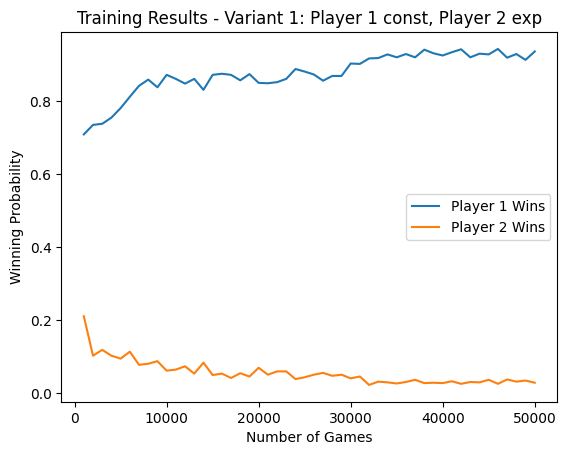

In [6]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Define your classes and functions here
# ... (Player and State class definitions)

if __name__ == "__main__":
    # Initialize players
    
    start_eps_decay = 0.7
    end_eps_decay = 0.3
    epsilon_decay = 30000
    
    p1 = Player("p1", exp_rate=0.2)
    p2 = Player("p2")
    p2.exp_rate = p2.exponential_decay(0, eps_decay=True, start_eps_decay=start_eps_decay, end_eps_decay=end_eps_decay, epsilon_decay=epsilon_decay)
    st = State(p1, p2)
    
    print("Training...")
    
    # Case 1: Player 1 constant exp_rate and Player 2 exponential decay rate
    variant_label = "Variant 1: Player 1 const, Player 2 exp"
    p1_winning_game_case1 = []
    p2_winning_game_case1 = []
    
    for rounds in range(1000, 51000, 1000):
        p1_win_intervals, p2_win_intervals= st.play(rounds)
        p1_winning_game_case1.append(p1_win_intervals[-1])
        p2_winning_game_case1.append(p2_win_intervals[-1])
        print(f"Number of Games: {rounds}")
        print(f"Winning Probability of Player 1: {p1_win_intervals[-1]}")
        print(f"Winning Probability of Player 2: {p2_win_intervals[-1]}")
        print("--------")


    print("Training completed.")

    # Plot the results for all three cases
    plt.plot(range(1000, 51000, 1000), p1_winning_game_case1, label="Player 1 Wins")
    plt.plot(range(1000, 51000, 1000), p2_winning_game_case1, label="Player 2 Wins")
    plt.xlabel("Number of Games")
    plt.ylabel("Winning Probability")
    plt.title("Training Results - " + variant_label)
    plt.legend()
    plt.show()


Training...
Number of Games: 1000
Winning Probability of Player 1: 0.65
Winning Probability of Player 2: 0.242
--------
Number of Games: 2000
Winning Probability of Player 1: 0.551
Winning Probability of Player 2: 0.31
--------
Number of Games: 3000
Winning Probability of Player 1: 0.52
Winning Probability of Player 2: 0.334
--------
Number of Games: 4000
Winning Probability of Player 1: 0.476
Winning Probability of Player 2: 0.381
--------
Number of Games: 5000
Winning Probability of Player 1: 0.454
Winning Probability of Player 2: 0.364
--------
Number of Games: 6000
Winning Probability of Player 1: 0.355
Winning Probability of Player 2: 0.413
--------
Number of Games: 7000
Winning Probability of Player 1: 0.353
Winning Probability of Player 2: 0.396
--------
Number of Games: 8000
Winning Probability of Player 1: 0.375
Winning Probability of Player 2: 0.405
--------
Number of Games: 9000
Winning Probability of Player 1: 0.381
Winning Probability of Player 2: 0.394
--------
Number of 

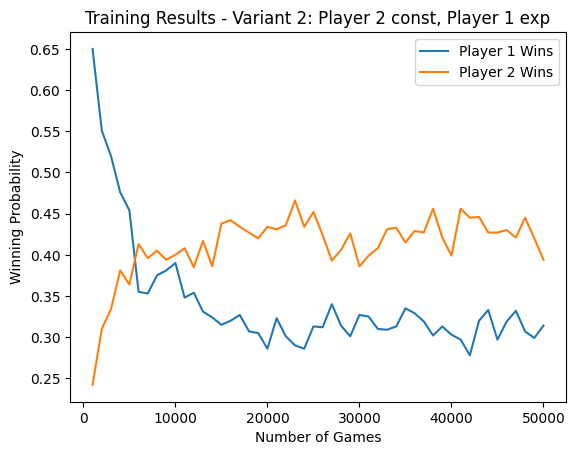

In [11]:
if __name__ == "__main__":
    # Initialize players
    
    start_eps_decay = 0.7
    end_eps_decay = 0.3
    epsilon_decay = 30000
    
    p1 = Player("p1")
    p1.exp_rate = p1.exponential_decay(0, start_eps_decay=start_eps_decay, end_eps_decay=end_eps_decay, epsilon_decay=epsilon_decay)
    
    p2 = Player("p2", exp_rate=0.2)
    st = State(p1, p2)
    
    print("Training...")
    variant_label = "Variant 2: Player 2 const, Player 1 exp"
    p1_winning_game = []
    p2_winning_game = []
    tie_game = []
    num_games = []

    for rounds in range(1000, 51000, 1000):
        p1_win_intervals, p2_win_intervals, tie_intervals = st.play(rounds)
        num_games.append(rounds)
        p1_winning_game.append(p1_win_intervals[-1])
        p2_winning_game.append(p2_win_intervals[-1])
        tie_game.append(tie_intervals[-1])
        print(f"Number of Games: {rounds}")
        print(f"Winning Probability of Player 1: {p1_win_intervals[-1]}")
        print(f"Winning Probability of Player 2: {p2_win_intervals[-1]}")
        print("--------")

    print("Training completed.")
    
    # Plot the results for the second variant
    plt.plot(num_games, p1_winning_game, label="Player 1 Wins")
    plt.plot(num_games, p2_winning_game, label="Player 2 Wins")
    plt.xlabel("Number of Games")
    plt.ylabel("Winning Probability")
    plt.title("Training Results - " + variant_label)
    plt.legend()
    plt.show()


In [19]:
if __name__ == "__main__":
# Initialize players
    start_eps_decay = 0.7
    end_eps_decay = 0.3
    epsilon_decay = 30000

    p1 = Player("p1")
    p1.exp_rate = p1.exponential_decay_value(0,start_eps_decay, end_eps_decay, epsilon_decay)

    p2 = Player("p2")
    p2.exp_rate = p2.exponential_decay_value(0,start_eps_decay, end_eps_decay, epsilon_decay)

    st = State(p1, p2)
    print("Training...")
    variant_label = "Variant 3: Player 1 exponential, Player 2 exponential"
    p1_winning_game = []
    p2_winning_game = []
    tie_game = []
    num_games = []

    for rounds in range(1000, 51000, 1000):
        
        p1_win_intervals, p2_win_intervals, tie_intervals = st.play(rounds)
        num_games.append(rounds)
        p1_winning_game.append(p1_win_intervals[-1])
        p2_winning_game.append(p2_win_intervals[-1])
        tie_game.append(tie_intervals[-1])
        print(f"Number of Games: {rounds}")
        print(f"Winning Probability of Player 1: {p1_win_intervals[-1]}")
        print(f"Winning Probability of Player 2: {p2_win_intervals[-1]}")
        print(f"Tie Games: {tie_intervals[-1]}")
        print("--------")


Training...
Number of Games: 1000
Winning Probability of Player 1: 0.657
Winning Probability of Player 2: 0.209
Tie Games: 0.134
--------
Number of Games: 2000
Winning Probability of Player 1: 0.661
Winning Probability of Player 2: 0.231
Tie Games: 0.108
--------
Number of Games: 3000
Winning Probability of Player 1: 0.648
Winning Probability of Player 2: 0.252
Tie Games: 0.1
--------
Number of Games: 4000
Winning Probability of Player 1: 0.606
Winning Probability of Player 2: 0.265
Tie Games: 0.129
--------
Number of Games: 5000
Winning Probability of Player 1: 0.649
Winning Probability of Player 2: 0.231
Tie Games: 0.12
--------
Number of Games: 6000
Winning Probability of Player 1: 0.624
Winning Probability of Player 2: 0.233
Tie Games: 0.143
--------
Number of Games: 7000
Winning Probability of Player 1: 0.622
Winning Probability of Player 2: 0.229
Tie Games: 0.149
--------
Number of Games: 8000
Winning Probability of Player 1: 0.648
Winning Probability of Player 2: 0.227
Tie Games

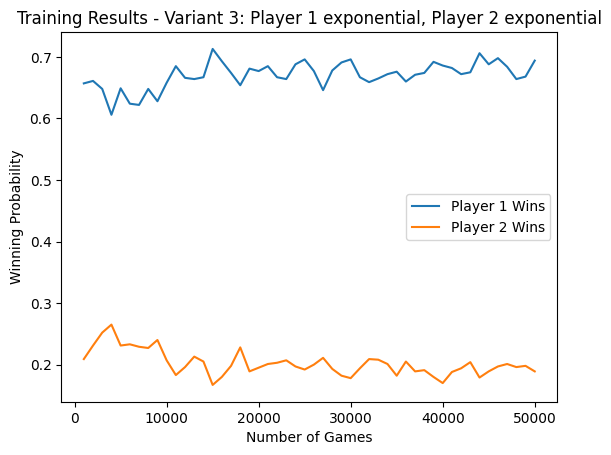

In [20]:

 # Plot the results for the second variant
plt.plot(num_games, p1_winning_game, label="Player 1 Wins")
plt.plot(num_games, p2_winning_game, label="Player 2 Wins")
plt.xlabel("Number of Games")
plt.ylabel("Winning Probability")
plt.title("Training Results - " + variant_label)
plt.legend()
plt.show()

In [21]:
# play with human

p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")
p2 = HumanPlayer("human")
st = State(p1, p2)
st.play2()
    

-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
 human action row:1
 human action col:2
-------------
|   |   |   | 
-------------
|   | x | o | 
-------------
|   |   |   | 
-------------
-------------
| x |   |   | 
-------------
|   | x | o | 
-------------
|   |   |   | 
-------------
 human action row:2
 human action col:2
-------------
| x |   |   | 
-------------
|   | x | o | 
-------------
|   |   | o | 
-------------
-------------
| x |   |   | 
-------------
|   | x | o | 
-------------
| x |   | o | 
-------------
 human action row:0
 human action col:2
-------------
| x |   | o | 
-------------
|   | x | o | 
-------------
| x |   | o | 
-------------
-------------
| x |   | o | 
-------------
| x | x | o | 
-------------
| x |   | o | 
-------------
computer wins!


In [23]:
# play with human

p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")
p2 = HumanPlayer("human")
st = State(p1, p2)
st.play2()

-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
 human action row:1
 human action col:0
-------------
|   |   |   | 
-------------
| o | x |   | 
-------------
|   |   |   | 
-------------
-------------
|   |   |   | 
-------------
| o | x |   | 
-------------
|   |   | x | 
-------------
 human action row:0
 human action col:0
-------------
| o |   |   | 
-------------
| o | x |   | 
-------------
|   |   | x | 
-------------
-------------
| o |   | x | 
-------------
| o | x |   | 
-------------
|   |   | x | 
-------------
 human action row:2
 human action col:0
-------------
| o |   | x | 
-------------
| o | x |   | 
-------------
| o |   | x | 
-------------
-------------
| o |   | x | 
-------------
| o | x | x | 
-------------
| o |   | x | 
-------------
computer wins!
